In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

В этом ноутбуке я тыкаюсь в код из материалов к лекциям, пытаюсь повторить какие-то эксперименты и графики, чтобы лучше понять сам материал


## Связь между $\alpha$, $\beta$, MDE

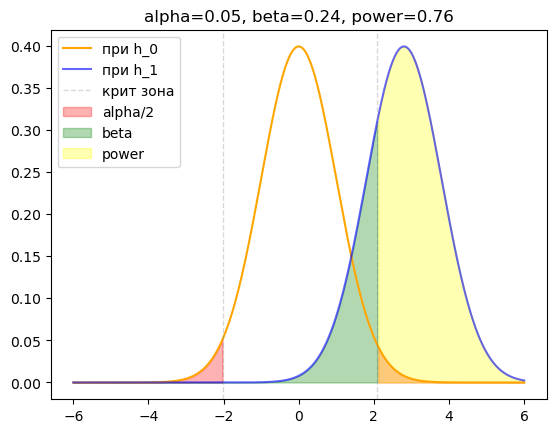

In [ ]:
mu = 0
sigma = 1
effect = 2.8
alpha = 0.05
beta = 0.2

x = np.linspace(-6, 6, 400)

h_0 = stats.norm(loc=mu, scale=sigma)
h_1 = stats.norm(loc=mu+effect, scale=sigma)
s = np.random.normal(mu, sigma, 1000)

#графики при h
plt.plot(x, h_0.pdf(x), label='при h_0', color='orange')
plt.plot(x, h_1.pdf(x), label='при h_1', color='blue', alpha=.6)


#лева критическая область
alpha_q = np.percentile(s, alpha/2*100)
x_fill = x[x <= alpha_q]
plt.axvline(alpha_q, label='крит зона', color='grey', alpha=.3, linewidth=1, ls='--')
plt.fill_between(x_fill, h_0.pdf(x_fill), 0, label='alpha/2', alpha=.3, color='red')

#правая критическая область
alpha_q = np.percentile(s, (1-alpha/2)*100)
x_fill = x[x >= alpha_q]
plt.fill_between(x_fill, h_0.pdf(x_fill), 0, alpha=.3, color='red')
plt.axvline(alpha_q, color='grey', alpha=.3, linewidth=1, ls='--')

x_fill = x[x <= alpha_q]
plt.fill_between(x_fill, h_1.pdf(x_fill), 0, label='beta', alpha=.3, color='green')
x_fill = x[x >= alpha_q]
plt.fill_between(x_fill, h_1.pdf(x_fill), 0, label='power', alpha=.3, color='yellow')

alpha_print = round(h_0.cdf(h_0.ppf(alpha/2)) + 1-h_0.cdf(h_0.ppf(1-alpha/2)), 3)
beta = round(h_1.cdf(np.percentile(s, (1-alpha/2)*100)),2)
power = round(1-beta, 3)

plt.title(f'alpha={alpha_print}, beta={round(beta, 3)}, power={power}')
plt.legend()

## Про валидацию критериев

### QQ-plot
QQ-plot - график, позволяющий визуально сравнить данные с теоретическим распроеделением

In [130]:
import numpy as np
import matplotlib.pyplot as plt

def QQ_plot(data, dist='norm'):
    #сортируем
    y = np.sort(data)
    N = len(y)

    #определяем распределение и считаем квантили
    if dist == 'norm':
        plt.title(f'QQ-plot Normal dist, n={N}')
        ppf = stats.norm(loc=np.mean(y), scale=np.std(y)).ppf
        x = [ppf(i/(N+2)) for i in range(1, N+1)]
    elif dist == 'uniform':
        plt.title(f'QQ-plot Uniform dist, n={N}')
        x = np.linspace(np.min(y), np.max(y), N)

    plt.scatter(x, y)
    
    diag = np.linspace(np.min([x,y]), np.max([x,y]), 1000)
    plt.plot(diag, diag, color='red', linestyle='--')
    plt.gca().set_aspect('equal')
    plt.xlabel('Normal quantiles')
    plt.ylabel('Sample quantiles')

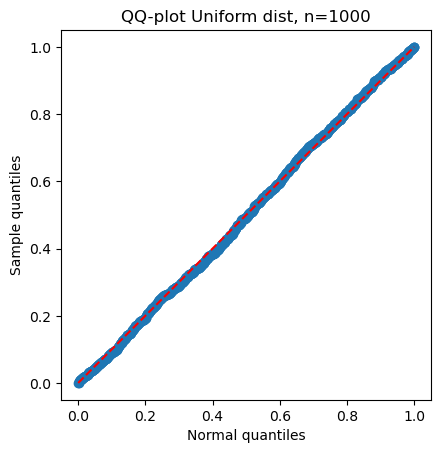

In [125]:
x = np.random.uniform(0, 1, size=1_000)
QQ_plot(x, dist='uniform')

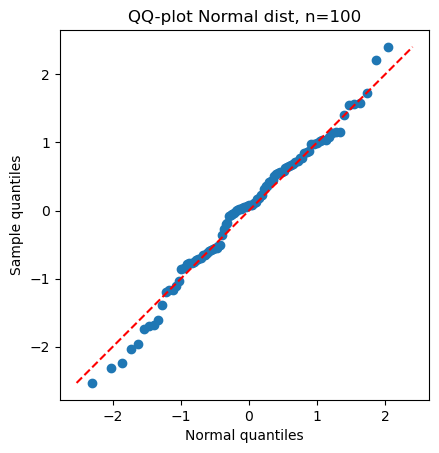

In [128]:
x = np.random.normal(0, 1, size=100)
QQ_plot(x, dist='norm')

### ЭФР (эмпирическая функция распределения)  
$F_n(x) = \frac{\text{число элементов выборки <= x}}{n} = \frac{[X_i <= x]}{n}$

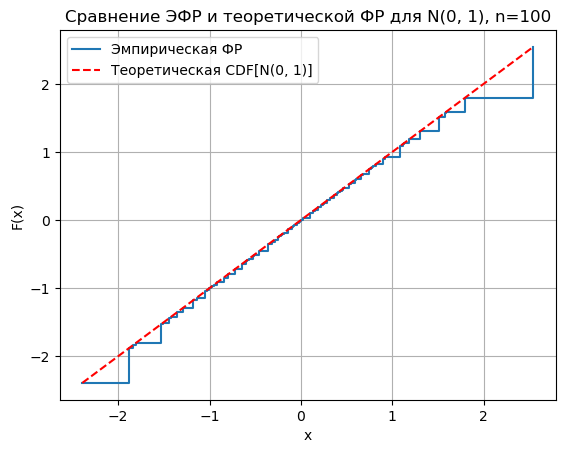

In [72]:
#Генерирую выборку размера n
n = 100
np.random.seed(62)
sample = np.random.normal(0, 1, n)

#Строю ЭФР
sorted_sample = np.sort(sample)
ecdf = stats.ecdf(sample).cdf.quantiles

#Теоретическая CDF для 
x_theor = cdf_theor = np.linspace(min(sample), max(sample), 100)

#Рисуем
plt.title(f'Сравнение ЭФР и теоретической ФР для N(0, 1), n={n}')
plt.step(sorted_sample, ecdf, where='post', label='Эмпирическая ФР')
plt.plot(x_theor, cdf_theor, 'r--', label='Теоретическая CDF[N(0, 1)]')
plt.xlabel('x')
plt.ylabel('F(x)')
# plt.ylim(-2.5, 2.5)
# plt.xlim(-2.5, 2.5)
plt.legend()
plt.grid(True)
plt.show()

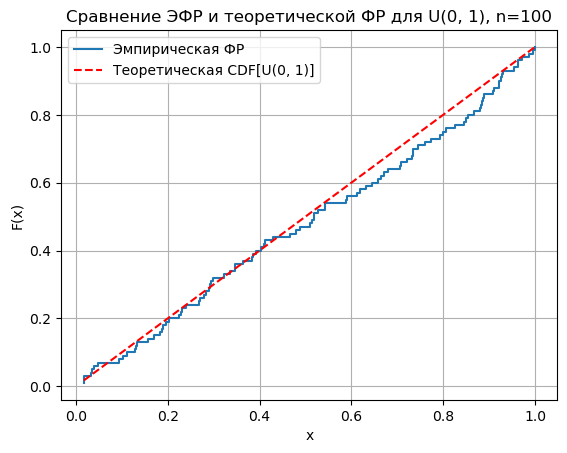

In [ ]:
#Генерирую выборку размера n
n = 100
np.random.seed(62)
sample = np.random.uniform(0, 1, n)

#Строю ЭФР
sorted_sample = np.sort(sample)
ecdf = np.arange(1, n+1)/n

#Теоретическая CDF для 
x_theor = cdf_theor = np.linspace(min(sample), max(sample), 100)

#Рисуем
plt.title(f'Сравнение ЭФР и теоретической ФР для U(0, 1), n={n}')
plt.step(sorted_sample, ecdf, where='post', label='Эмпирическая ФР')
plt.plot(x_theor, cdf_theor, 'r--', label='Теоретическая CDF[U(0, 1)]')
plt.xlabel('x')
plt.ylabel('F(x)')
# plt.ylim(-2.5, 2.5)
# plt.xlim(-2.5, 2.5)
plt.legend()
plt.grid(True)
plt.show()

## Доверительные интервалы
При нормальном распределении $\frac{\bar X_t - \bar X_c}{\^{\sigma}} \rightarrow  N(\frac{e}{\^{\sigma}}, 1)$ логично, что нормированное значение эффекта будет находиться в интервале:
$$
z_{\alpha/2} \leq \frac{\Delta - e}{\^{\sigma}} \leq z_{1-\alpha/2}
$$
Преобразуем и получим:
$$e \in \Delta \pm z_{1-\alpha/2} \^{\sigma}$$

In [1]:
def safe_divide(x, y):
    try:
        return x / y
    except ZeroDivisionError:
        return np.nan
    
def delta_var(numerator, denominator):
    x = numerator
    y = denominator
    n = len(x)
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]    
    delta_var = safe_divide(safe_divide(var_x,mu_y**2)  - 2*cov_xy*safe_divide(mu_x,mu_y**3) + var_y*safe_divide(mu_x**2,mu_y**4), n)
    return delta_var

In [ ]:
df = pd.read_csv('synthetic_gmv_data_1.2.csv')

data = df.groupby(['user_id', 'group_name'], as_index=False).agg({'gmv': 'sum', 'user_id':'count'})
a = data.loc[data.group_name == 'control']
b = data.loc[data.group_name == 'test']
data

,group_name,gmv,user_id
0,control,733,1
1,test,3187,3
2,control,2933,6
3,test,1695,5
4,control,1496,4
...,...,...,...
196386,test,1141,2
196387,control,2364,4
196388,test,1923,4
196389,control,1235,2


In [10]:
alpha = 0.05
n = a.gmv.shape[0]
m = b.gmv.shape[0]

test_var = delta_var(a.gmv, np.ones(a.gmv.shape[0]))
control_var = delta_var(b.gmv, np.ones(b.gmv.shape[0]))
sigma = np.sqrt(test_var + control_var)
print(f'Sigma: {round(sigma, 3)}')

delta = b.gmv.mean() - a.gmv.mean() 
print(f'Delta GMV: {(round(delta, 3))}')

l = round(delta - stats.t.ppf(1-alpha/2, n+m-2) * np.sqrt(test_var), 3)
r = round(delta + stats.t.ppf(1-alpha/2, n+m-2) * np.sqrt(test_var), 3)

print(f'CI: [{l}, {r}]')

Sigma: 9.928
Delta GMV: 23.433
CI: [13.79, 33.077]


## Дисперсия дельта-методом

## Тест Манна — Уитни

## Тест Шапиро — Уилка

## Критерий Колмогорова-Смирнова